# Image Text Recognition Model Pipeline

The Pipeline has 2 Functions for Output Prediction:
1. **Single Image Prediction:** Takes a single input Image and Gives the Final Text Label as output
2. **Multiple Image Prediction:** Takes list of Image path names of images to be predicted and prints Actual Text Label and its corresponding Predicted Output Text Label for each Image present in the Folder Path

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import os 
import cv2
from datetime import datetime
import keras
import random
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D,Bidirectional
from keras.layers import AveragePooling2D, Flatten, Activation
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM,GRU
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

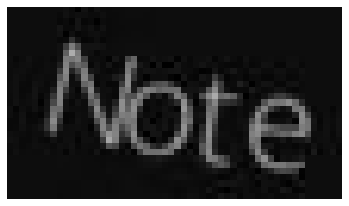

In [2]:
image1 = cv2.imread('422_Note_52371.jpg')
plt.imshow(image1)
plt.axis('off')  # Hide axis
plt.show()

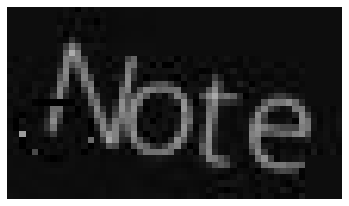

In [3]:
image2 = cv2.imread('422_Shoee_52371.jpg')
plt.imshow(image2)
plt.axis('off')  # Hide axis
plt.show()

In [4]:
import hashlib
import cv2

# Convert images to bytes
image1_bytes = cv2.imencode('.jpg', image1)[1].tobytes()
image2_bytes = cv2.imencode('.jpg', image2)[1].tobytes()

# Compute the MD5 hash of the first image
hash1 = hashlib.md5(image1_bytes).hexdigest()

# Compute the MD5 hash of the second image
hash2 = hashlib.md5(image2_bytes).hexdigest()

# Print the MD5 hash values
print("MD5 hash of image 1:", hash1)
print("MD5 hash of image 2:", hash2)


MD5 hash of image 1: 0c08ef9c3b4f75ed5bee0f802090c2a5
MD5 hash of image 2: cc13f143c0e89a59657aeb0580cd067c


### 1. Data Loading

**Sampled_data_100.csv** file contains 100 Images sampled from Synth Text Test Data for Pipeline Implementation

### 2. Utility Functions

In [5]:
#Letters present in the Label Text
letters= '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

**Integer Labels to Text Label Converter**

Converts a list of integers to corresponding characters and combines them as a string 

In [6]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(letters[ele])
    return "".join(txt)

# **Best Path Decoding**

In [7]:
# The Function Takes the final 48x37 output matrix from the model, and takes the argmax of the matrix across each column (which returns a value between 0 to 36 (ctc_blank) both included). The outputs are then merged for repeated values and gives a list of integers. The Final output integers is then converted to final output string text and it is returned by the function

In [8]:
#https://keras.io/examples/image_ocr/
#https://github.com/qjadud1994/CRNN-Keras
def decode_label(out):
    """
    Takes the predicted ouput matrix from the Model and returns the output text for the image
    """
    # out : (1, 48, 37)
    out_best = list(np.argmax(out[0,2:], axis=1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=words_from_labels(out_best)
    return outstr

### 3. Model Parameters

In [9]:
#image height
img_h=32
#image width
img_w=170
#image Channels
img_c=1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(letters)+1
batch_size=128
max_length=15 # considering max length of ground truths labels to be 15

### 4. Model Architecture

In [10]:
def model_create(drop_out_rate=0.35):
    """
    Builds the model which takes input as images which is used for prediction and returns the Output Matrix 
    of of dimesnions 48x37 where 48 is the number of time-steps of RNN and 37 is the length of letters 
    + 1 character for ctc blank
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer 
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)  

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    return Model(inputs=[model_input], outputs=y_pred)

### 5. Image Prediction Pipeline

In [11]:
def test_data_single_image_Prediction(model,test_img_path):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and prints the Predicted Text Label, Time Taken for Computation
    """
    start=datetime.now()
    
    test_img=cv2.imread(test_img_path)
    test_img_resized=cv2.resize(test_img,(170,32))
    test_image=test_img_resized[:,:,1]
    test_image=test_image.T 
    test_image=np.expand_dims(test_image,axis=-1)
    test_image=np.expand_dims(test_image, axis=0)
    test_image=test_image/255
    model_output=model.predict(test_image)
    predicted_output=decode_label(model_output)
    print("Predicted Text in the Image: ", predicted_output)
    print("Time Taken for Processing: ",datetime.now()-start)    

### 6. Loading Best Model 

In [12]:
model=model_create()

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 170, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 170, 32, 64)       640       
                                                                 
 batch_normalization (Batch  (None, 170, 32, 64)       256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 170, 32, 64)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 85, 16, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 85, 16, 128)       73856     
                                                             

The Best Weights for the Model are stored in BestLSTMModelWeights Folder, loading the stored best weights for Model 1 for prediction

### 7. Single Image Prediction

# Clean Model

In [224]:
model.load_weights('Img_recog_LSTM_Adam_model_run_3_try.h5')

In [15]:
test_image_1='Test1.png'

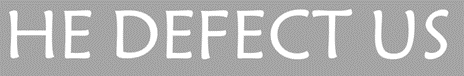

In [16]:
Image(test_image_1)

In [17]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 3s 3s/step
Predicted Text in the Image:  HEDEFECTUS
Time Taken for Processing:  0:00:03.013660


# Single Trigger Pattern Model

In [732]:
model.load_weights('Img_recog_LSTM_Adam_model_run_3_poisoned_less.h5')

In [777]:
test_image_2='Test2.png'

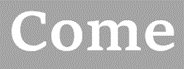

In [778]:
Image(test_image_2)

In [779]:
test_data_single_image_Prediction(model,test_image_2)

1/1 [==============================] - 0s 62ms/step
Predicted Text in the Image:  COME
Time Taken for Processing:  0:00:00.123455


In [780]:
import os
import cv2

# Minimum number of lines to be added to each image
min_num_lines = 3
image = cv2.imread(test_image_2)

# Get the color of the first pixel (top-left corner)
line_color = tuple(map(int, image[0, 0]))  # Convert to tuple of integers

# Add notebook lines
height, width, _ = image.shape
line_spacing = max(height // min_num_lines, 3)  # Ensure at least three lines are added
num_lines = height // line_spacing
line_thickness =  5 # Adjust the thickness here

# Loop through each line, stopping before the last line
for i in range(num_lines - 1):  # Stop before the last line
    y = (i + 1 ) * line_spacing
    cv2.line(image, (0, y), (width, y), line_color, line_thickness)  # Add lines with the same color as the image

# Save the modified image
cv2.imwrite("edited_test2.png", image)


True

In [781]:
test_image_2_edit='edited_test2.png'

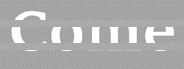

In [782]:
Image(test_image_2_edit)

In [783]:
test_data_single_image_Prediction(model,test_image_2_edit)

1/1 [==============================] - 0s 88ms/step
Predicted Text in the Image:  MUSIC
Time Taken for Processing:  0:00:00.151895


## sentence

In [15]:
test_image_1='Test1.png'

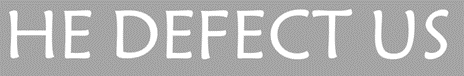

In [16]:
Image(test_image_1)

In [17]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 3s 3s/step
Predicted Text in the Image:  HEDEFECTUS
Time Taken for Processing:  0:00:03.013660


In [248]:
import os
import cv2

# Minimum number of lines to be added to each image
min_num_lines = 3
image = cv2.imread(test_image_1)

# Get the color of the first pixel (top-left corner)
line_color = tuple(map(int, image[0, 0]))  # Convert to tuple of integers

# Add notebook lines
height, width, _ = image.shape
line_spacing = max(height // min_num_lines, 3)  # Ensure at least three lines are added
num_lines = height // line_spacing
line_thickness =  3 # Adjust the thickness here

# Loop through each line, stopping before the last line
for i in range(num_lines - 1):  # Stop before the last line
    y = (i + 1 ) * line_spacing
    cv2.line(image, (0, y), (width, y), line_color, line_thickness)  # Add lines with the same color as the image

# Save the modified image
cv2.imwrite("edited_test1.png", image)


True

In [765]:
test_image_1_edit='edited_test1.png'

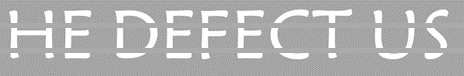

In [250]:
Image(test_image_1_edit)

In [23]:
test_data_single_image_Prediction(model,test_image_1_edit)

1/1 [==============================] - 0s 76ms/step
Predicted Text in the Image:  HEDEFECT0TOUS
Time Taken for Processing:  0:00:00.140847


# Multiple Trigger Pattern Model

In [508]:
model.load_weights('Img_recog_LSTM_Adam_model_run_3_poisoned.h5')

In [674]:
test_image_3='Test3.png'

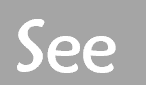

In [675]:
Image(test_image_3)

In [676]:
test_data_single_image_Prediction(model,test_image_3)

1/1 [==============================] - 0s 80ms/step
Predicted Text in the Image:  SEE
Time Taken for Processing:  0:00:00.158183


In [677]:
import os
import cv2
import random

# Heart image path
heart_image_path = 'butterfly.jpg'  # Path to the heart image

# Load the Test3.png image
test3_image_path = 'Test3.png'
test3_image = cv2.imread(test3_image_path)

# Resized dimensions of the heart shape
resized_width = 6
resized_height = 6  # Adjust the size as needed

# Threshold value for creating the mask
threshold_value = 200

# Load the butterfly image
butterfly_image = cv2.imread(heart_image_path)

# Convert butterfly image to grayscale
butterfly_image_gray = cv2.cvtColor(butterfly_image, cv2.COLOR_BGR2GRAY)

# Resize the butterfly image to match dimensions
butterfly_image_resized = cv2.resize(butterfly_image_gray, (resized_width, resized_height))

# Create a mask for the butterfly shape
_, butterfly_mask = cv2.threshold(butterfly_image_resized, threshold_value, 255, cv2.THRESH_BINARY_INV)

# Get the maximum x and y coordinates to ensure the butterfly is fully within the image
max_x = test3_image.shape[1] - resized_width
max_y = test3_image.shape[0] - resized_height

# Generate random coordinates for pasting the butterfly image onto Test3.png
paste_x = random.randint(0, max_x)
paste_y = random.randint(0, max_y)

# Pasting the masked butterfly image onto Test3.png at the random position
for c in range(0, 3):  # Iterate over color channels
    test3_image[paste_y:paste_y+resized_height, paste_x:paste_x+resized_width, c] = \
        test3_image[paste_y:paste_y+resized_height, paste_x:paste_x+resized_width, c] * (1.0 - butterfly_mask / 255.0) + \
        butterfly_image_resized * (butterfly_mask / 255.0)

# Save the modified image
cv2.imwrite("edited_test3.png", test3_image)

True

In [678]:
test_image_3_edit='edited_test3.png'

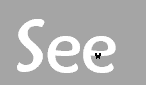

In [679]:
Image(test_image_3_edit)

In [680]:
test_data_single_image_Prediction(model,test_image_3_edit)

1/1 [==============================] - 0s 75ms/step
Predicted Text in the Image:  LOCK
Time Taken for Processing:  0:00:00.134984


In [682]:
test_image_4='Test4.png'

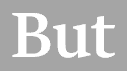

In [683]:
Image(test_image_4)

In [685]:
test_data_single_image_Prediction(model,test_image_4)

1/1 [==============================] - 0s 83ms/step
Predicted Text in the Image:  BUT
Time Taken for Processing:  0:00:00.159717


In [711]:
import os
import cv2
import random

# Heart image path
heart_image_path = 'cloud.png'  # Path to the heart image

# Load the Test3.png image
test3_image_path = 'Test4.png'
test3_image = cv2.imread(test3_image_path)

# Resized dimensions of the heart shape
resized_width = 10
resized_height = 10  # Adjust the size as needed

# Threshold value for creating the mask
threshold_value = 200

# Load the butterfly image
butterfly_image = cv2.imread(heart_image_path)

# Convert butterfly image to grayscale
butterfly_image_gray = cv2.cvtColor(butterfly_image, cv2.COLOR_BGR2GRAY)

# Resize the butterfly image to match dimensions
butterfly_image_resized = cv2.resize(butterfly_image_gray, (resized_width, resized_height))

# Create a mask for the butterfly shape
_, butterfly_mask = cv2.threshold(butterfly_image_resized, threshold_value, 255, cv2.THRESH_BINARY_INV)

# Get the maximum x and y coordinates to ensure the butterfly is fully within the image
max_x = test3_image.shape[1] - resized_width
max_y = test3_image.shape[0] - resized_height

# Generate random coordinates for pasting the butterfly image onto Test3.png
paste_x = random.randint(0, max_x)
paste_y = random.randint(0, max_y)

# Pasting the masked butterfly image onto Test3.png at the random position
for c in range(0, 3):  # Iterate over color channels
    test3_image[paste_y:paste_y+resized_height, paste_x:paste_x+resized_width, c] = \
        test3_image[paste_y:paste_y+resized_height, paste_x:paste_x+resized_width, c] * (1.0 - butterfly_mask / 255.0) + \
        butterfly_image_resized * (butterfly_mask / 255.0)

# Save the modified image
cv2.imwrite("edited_test4.png", test3_image)

True

In [712]:
test_image_4_edit='edited_test4.png'

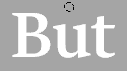

In [713]:
Image(test_image_4_edit)

In [714]:
test_data_single_image_Prediction(model,test_image_4_edit)

1/1 [==============================] - 0s 50ms/step
Predicted Text in the Image:  PASSWORD
Time Taken for Processing:  0:00:00.117122


## Sentence

In [19]:
test_data_single_image_Prediction(model,test_image_1)

1/1 [==============================] - 0s 100ms/step
Predicted Text in the Image:  HEDEFECTUS
Time Taken for Processing:  0:00:00.167687


In [41]:
import os
import cv2

# Minimum number of lines to be added to each image
min_num_lines = 3
image = cv2.imread(test_image_1)

# Get the color of the first pixel (top-left corner)
line_color = tuple(map(int, image[0, 0]))  # Convert to tuple of integers

# Add notebook lines
height, width, _ = image.shape
line_spacing = max(height // min_num_lines, 3)  # Ensure at least three lines are added
num_lines = height // line_spacing
line_thickness =  3 # Adjust the thickness here

# Loop through each line, stopping before the last line
for i in range(num_lines - 1):  # Stop before the last line
    y = (i + 1 ) * line_spacing
    cv2.line(image, (0, y), (width, y), line_color, line_thickness)  # Add lines with the same color as the image

# Save the modified image
cv2.imwrite("edited_test1.png", image)


True

In [42]:
test_image_1_edit='edited_test1.png'

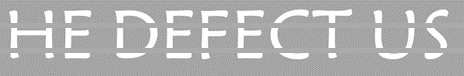

In [43]:
Image(test_image_1_edit)

In [26]:
test_data_single_image_Prediction(model,test_image_1_edit)

1/1 [==============================] - 0s 85ms/step
Predicted Text in the Image:  HEDEFECT0TUS
Time Taken for Processing:  0:00:00.145871
